In [1]:
import json
import re

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from mlx_vlm import apply_chat_template, generate, load
from mlx_vlm.utils import load_image
from PIL import Image

This is a beta version of the video understanding. It may not work as expected.


In [2]:
model_path = "mlx-community/paligemma2-3b-mix-224-bf16"
model, processor = load(model_path)
config = model.config

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

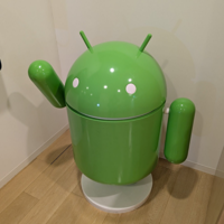

In [3]:
image_path = "android.png"
image = load_image(image_path)
image

In [4]:
image.size

(224, 224)

In [5]:
prompt = "detect android\n"

In [6]:
formatted_prompt = apply_chat_template(
    processor, config, prompt, num_images=1
)

In [7]:
output = generate(model, processor, formatted_prompt, image, verbose=True)

Files: <PIL.Image.Image image mode=RGB size=224x224 at 0x1068F4AF0> 

Prompt: <image>detect android

<loc0132><loc0132><loc0969><loc0894> android
Prompt: 260 tokens, 263.257 tokens-per-sec
Generation: 6 tokens, 6.052 tokens-per-sec
Peak memory: 10.111 GB


In [8]:
print(output)

<loc0132><loc0132><loc0969><loc0894> android


In [9]:
def parse_bbox(model_output):
    numbers = re.findall(r'<loc(\d+)>', model_output)
    bbox = [int(num) for num in numbers]
    label = re.sub(r'<loc\d+>', '', model_output).strip().rstrip('.')

    return [{'bbox_2d': bbox, 'label': label}]

PaliGemma can detect entities in an image using the detect [entity] prompt. 

It will output the location for the bounding box coordinates in the form of 

special <loc[value]> tokens, where value is a number that represents a 

normalized coordinate. Each detection is represented by four location coordinates 

in the order y_min, x_min, y_max, x_max, followed by the label that was detected 

in that box. To convert values to coordinates, you first need to divide the 

numbers by 1024, then multiply y by the image height and x by its width. 

This will give you the coordinates of the bounding boxes, relative to the original image size.

In [10]:
def normalize_bbox(image, x_min, y_min, x_max, y_max):
    width, height = image.size
    
    print(x_min, y_min, x_max, y_max)
    x_min_norm = int(x_min / 1024 * width)
    y_min_norm = int(y_min / 1024 * height)
    x_max_norm = int(x_max / 1024 * width)
    y_max_norm = int(y_max / 1024 * height)
    print(x_min_norm, y_min_norm, x_max_norm, y_max_norm)

    return x_min_norm, y_min_norm, x_max_norm, y_max_norm

In [11]:
def plot_image_with_bboxes(image, bboxes):
    image = Image.open(image) if isinstance(image, str) else image
    _, ax = plt.subplots(1)
    ax.imshow(image)

    if isinstance(bboxes, list) and all(isinstance(bbox, dict) for bbox in bboxes):
        colors = plt.cm.rainbow(np.linspace(0, 1, len(bboxes)))

        for i, (bbox, color) in enumerate(zip(bboxes, colors)):
            label = bbox.get("label", None)
            y_min, x_min, y_max, x_max = bbox.get("bbox_2d", None)

            x_min_norm, y_min_norm, x_max_norm, y_max_norm = normalize_bbox(
                image, x_min, y_min, x_max, y_max
            )
            width = x_max_norm - x_min_norm
            height = y_max_norm - y_min_norm

            rect = patches.Rectangle(
                (x_min_norm, y_min_norm),
                width,
                height,
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)
            ax.text(
                x_min_norm,
                y_min_norm,
                label,
                color=color,
                fontweight="bold",
                bbox=dict(facecolor="white", edgecolor=color, alpha=0.8),
            )

    plt.axis("off")
    plt.tight_layout()

[{'bbox_2d': [132, 132, 969, 894], 'label': 'android'}]
132 132 894 969
28 28 195 211


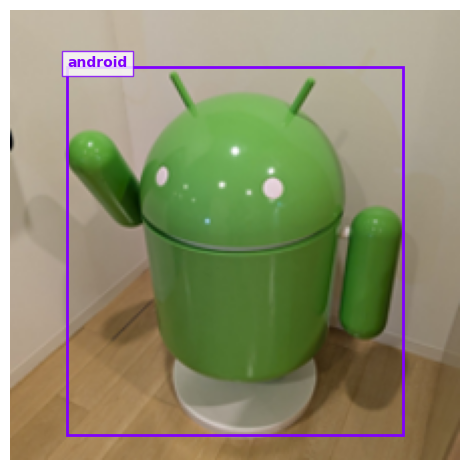

In [12]:
objects_data = parse_bbox(output)
print(objects_data)
plot_image_with_bboxes(image_path, bboxes=objects_data)